In [1]:
%cd ..

/home/burak/repos/smartrag


In [2]:
from disambiguation_methods.qa import chain_answer, IS_BOOL
from disambiguation_methods.score import chain_score
from disambiguation_methods.score_2 import chain_score as chain_score2

from collections import defaultdict
from disambiguation_methods.qa import AnswerStr
from disambiguation_methods.score import AnswerJudge
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnableConfig
from models import QueryAmbiguation
import pandas as pd
import json
from disambiguation_methods.domain_extractor import categories

from tqdm import tqdm

In [3]:
top_n = 10
dataset_name = "unfiltered/finqabench"
# experiment = f"top{top_n}+DOMAIN+LLM+Intent+MLM+TE+LLM"
experiment = "unfiltered+DOMAIN+Intent+Dtype"

In [4]:
df = pd.read_csv(f"./data/{dataset_name}_{experiment}.csv")

### Ambiguity Experiments

In [5]:
lm1 = RunnableLambda(lambda x: chain_answer.invoke(x["amb"]))
lm2 = RunnableLambda(lambda x: chain_answer.invoke(x["unamb"]))
lm3 = RunnableLambda(lambda x: chain_answer.invoke(x["disamb"]))
chain_ = RunnableParallel(amb=lm1, unamb=lm2, disamb=lm3)

In [15]:
methods = [
    "MLM",
    "TE",
    "LLM",
    "LLM_NO_INTENT",
    "LLM_NO_DOMAIN",
    "LLM_NO_DTYPE",
    "LLM_SUGGEST_ONLY",
]
# methods = [
#     "MLM",
#     "TE",
#     "LLM",
#     "MLM_NO_INTENT",
#     "MLM_NO_DOMAIN",
#     "TE_NO_INTENT",
#     "TE_NO_DOMAIN",
#     "LLM_NO_INTENT",
#     "LLM_NO_DOMAIN",
#     # "LLM_NO_DTYPE",
#     "LLM2",
# ]

In [16]:
for method in methods:
    for df_index in tqdm(range(len(df))):
        ambiguities = QueryAmbiguation(**json.loads(df.loc[df_index, "possible_ambiguities"]))
        if "LLM_SUGGEST_ONLY" not in method:
            most_likely_full_forms: list[str] = json.loads(
                df.loc[df_index, f"{method.split("_")[0]}_most_likely_full_forms"]
            )
        else:
            most_likely_full_forms: list[str] = json.loads(df.loc[df_index, f"llm_full_form_suggestions"])

        disambiguated_question_answers = []
        unambiguous_question_answers = []
        ambiguous_question_answers = []

        evaluation = {"amb": [], "disamb": [], "unamb": []}

        for full_form, amb in zip(most_likely_full_forms, ambiguities.full_form_abbrv_map):
            amb_question: str = df.loc[df_index, "ambiguous_question"]
            unamb_question: str = df.loc[df_index, "unambiguous_question"]

            disambiguated_question = amb_question.replace(amb.abbreviation, amb.abbreviation + f" ({full_form})")
            df.loc[df_index, "disambiguated_question"] = disambiguated_question

            answer: str = df.loc[df_index, "answer"] if "answer" in df else ""

            response: dict[str, AnswerStr] = chain_.invoke(
                {
                    "amb": {
                        "query": amb_question,
                        "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                        "domain": df.loc[df_index, "domain"] if "NO_DOMAIN" not in method else "'Not Specified'",
                        "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                    },
                    "unamb": {
                        "query": unamb_question,
                        "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                        "domain": df.loc[df_index, "domain"] if "NO_DTYPE" not in method else "'Not Specified'",
                        "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                    },
                    "disamb": {
                        "query": disambiguated_question,
                        "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                        "domain": df.loc[df_index, "domain"] if "NO_DTYPE" not in method else "'Not Specified'",
                        "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                    },
                },
                RunnableConfig(configurable={"llm": "gpt35"}),
            )

            response_: AnswerJudge = chain_score.invoke(
                {
                    "answer": answer if answer else response["unamb"].answer,
                    "amb": response["amb"].answer,
                    "unamb": response["unamb"].answer,
                    "disamb": response["disamb"].answer,
                    "query": unamb_question,
                }
            )
            # amb, unamb, disamb

            disambiguated_question_answers.append(response["disamb"].answer)
            unambiguous_question_answers.append(response["unamb"].answer)
            ambiguous_question_answers.append(response["amb"].answer)

            evaluation["amb"].append(response_.bit1 == 1)
            evaluation["unamb"].append(response_.bit2 == 1)
            evaluation["disamb"].append(response_.bit3 == 1)

        df.loc[df_index, f"{method}_disambiguated_question_answered_by_gpt35_correct"] = json.dumps(
            evaluation["disamb"]
        )
        df.loc[df_index, f"{method}_unambiguous_question_answered_by_gpt35_correct"] = json.dumps(evaluation["unamb"])
        df.loc[df_index, f"{method}_ambiguous_question_answered_by_gpt35_correct"] = json.dumps(evaluation["amb"])

        df.loc[df_index, f"{method}_disambiguated_question_answered_by_gpt35"] = json.dumps(
            disambiguated_question_answers
        )
        df.loc[df_index, f"{method}_unambiguous_question_answered_by_gpt35"] = json.dumps(unambiguous_question_answers)
        df.loc[df_index, f"{method}_ambiguous_question_answered_by_gpt35"] = json.dumps(ambiguous_question_answers)

  0%|          | 0/208 [00:00<?, ?it/s]


KeyError: 'domain'

In [10]:
df = pd.read_csv("./data/medquad_ambiguous_top10+DOMAIN+LLM+Intent+MLM+TE+LLM+eval.csv")

In [17]:
import numpy as np

eval_df = pd.DataFrame(columns=["method", "ambiguous_accuracy", "unambiguous_accuracy", "disambiguated_accuracy"])

for method in methods:
    eval_df = pd.concat(
        [
            eval_df,
            pd.DataFrame(
                [
                    {
                        "method": method,
                        "ambiguous_accuracy": df[f"{method}_ambiguous_question_answered_by_gpt35_correct"]
                        .apply(lambda x: np.mean(json.loads(x)))
                        .mean(),
                        "unambiguous_accuracy": df[f"{method}_unambiguous_question_answered_by_gpt35_correct"]
                        .apply(lambda x: np.mean(json.loads(x)))
                        .mean(),
                        "disambiguated_accuracy": df[f"{method}_disambiguated_question_answered_by_gpt35_correct"]
                        .apply(lambda x: np.mean(json.loads(x)))
                        .mean(),
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
eval_df

/tmp/ipykernel_24125/2503680394.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat(


,method,ambiguous_accuracy,unambiguous_accuracy,disambiguated_accuracy
0,MLM,0.591346,0.860577,0.490385
1,TE,0.586538,0.865385,0.600962
2,LLM,0.579327,0.872596,0.687500
3,MLM_NO_INTENT,0.593750,0.879808,0.507212
4,MLM_NO_DOMAIN,0.543269,0.887019,0.461538
5,TE_NO_INTENT,0.588942,0.877404,0.610577
6,TE_NO_DOMAIN,0.545673,0.879808,0.512019
7,LLM_NO_INTENT,0.552885,0.882212,0.646635
8,LLM_NO_DOMAIN,0.550481,0.889423,0.675481
9,LLM2,0.586538,0.865385,0.629808


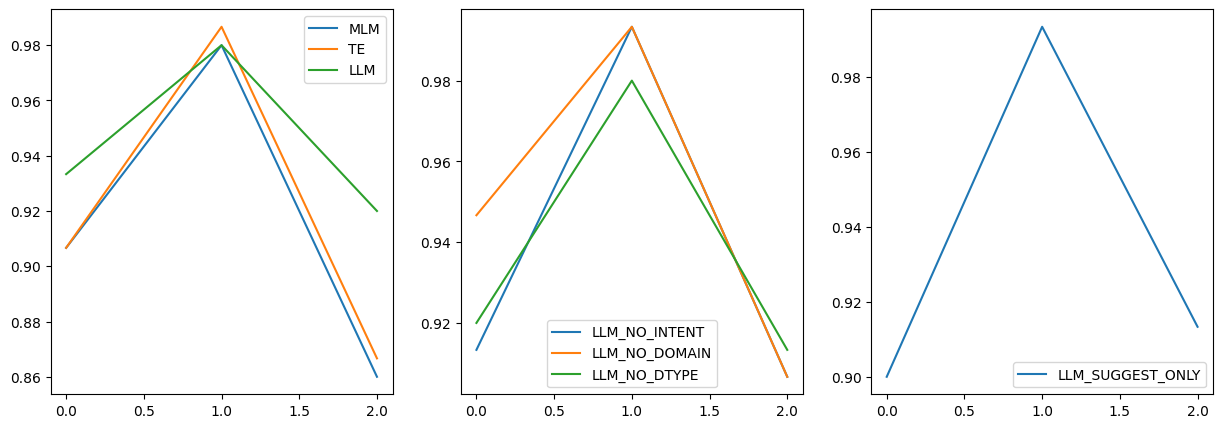

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, row in eval_df.iterrows():
    axes[int(i) // 3].plot(
        range(3),
        [row["ambiguous_accuracy"], row["unambiguous_accuracy"], row["disambiguated_accuracy"]],
        label=row["method"],
    )
    axes[int(i) // 3].legend()
plt.show()

In [11]:
df.to_csv(f"./data/{dataset_name}_{experiment}_top{top_n}+DOMAIN+Intent+Dtype+MLM+TE+LLM+eval.csv", index=False)

In [4]:
df = pd.read_csv(f"./data/{dataset_name}_ambiguous_top{top_n}+DOMAIN+LLM+Intent+MLM+TE+LLM+eval.csv")

### Intent+Domain+Dtype Experiments

In [5]:
lm1 = RunnableLambda(lambda x: chain_answer.invoke(x["raw"]))
lm2 = RunnableLambda(lambda x: chain_answer.invoke(x["analyzed"]))
chain_ = RunnableParallel(raw=lm1, analyzed=lm2)

In [13]:
methods = [
    "RAW_NO_DTYPE",
    "RAW_ALL",
    "RAW_NO_DOMAIN",
    "RAW_NO_INTENT",
]

In [12]:
from disambiguation_methods.qa import AnswerBool

llm_name = "gpt35"

for method in methods:
    for df_index in tqdm(range(len(df))):
        question: str = df.loc[df_index, "question"]
        answer: str | bool = df.loc[df_index, "answer"] if "answer" in df else ""

        response: dict[str, AnswerStr | AnswerBool] = chain_.invoke(
            {
                "analyzed": {
                    "query": question,
                    "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                    "domain": df.loc[df_index, "domain"] if "NO_DOMAIN" not in method else "'Not Specified'",
                    "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                },
                "raw": {
                    "query": question,
                    "intent": "'Not Specified'",
                    "domain": "'Not Specified'",
                    "dtype": "'Not specified'",
                },
            },
            RunnableConfig(configurable={"llm": llm_name}),
        )
        if not IS_BOOL:
            response_: AnswerJudge = chain_score2.invoke(
                {
                    "answer": answer if answer else response["raw"].answer,
                    "raw": response["raw"].answer,
                    "analyzed": response["analyzed"].answer,
                    "query": question,
                }
            )

            df.loc[df_index, f"{method}_raw_question_answered_by_{llm_name}_correct"] = response_.bit1 == 1
            df.loc[df_index, f"{method}_analyzed_question_answered_by_{llm_name}_correct"] = response_.bit2 == 1
        else:
            df.loc[df_index, f"{method}_raw_question_answered_by_{llm_name}_correct"] = response["raw"].answer == answer
            df.loc[df_index, f"{method}_analyzed_question_answered_by_{llm_name}_correct"] = (
                response["analyzed"].answer == answer
            )

        df.loc[df_index, f"{method}_analyzed_question_answered_by_{llm_name}"] = response["analyzed"].answer
        df.loc[df_index, f"{method}_raw_question_answered_by_{llm_name}"] = response["raw"].answer

100%|██████████| 100/100 [03:22<00:00,  2.02s/it]


In [18]:
# df = df.rename(
#     columns={
#         col: col.replace("raw", "analyzed")
#         if "raw" in col
#         else (col.replace("analyzed", "raw") if "analyzed" in col else col)
#         for col in df.columns
#     }
# )

In [14]:
eval_df = pd.DataFrame(columns=["method", "raw_accuracy", "analyzed_accuracy"])

for method in methods:
    eval_df = pd.concat(
        [
            eval_df,
            pd.DataFrame(
                [
                    {
                        "method": method,
                        "raw_accuracy": (df[f"{method}_raw_question_answered_by_{llm_name}_correct"] * 1.0).mean(),
                        "analyzed_accuracy": (
                            df[f"{method}_analyzed_question_answered_by_{llm_name}_correct"] * 1.0
                        ).mean(),
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
eval_df

/tmp/ipykernel_39481/3163220987.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat(


,method,raw_accuracy,analyzed_accuracy
0,RAW_NO_DTYPE,0.42,0.49
1,RAW_ALL,0.47,0.44
2,RAW_NO_DOMAIN,0.47,0.42
3,RAW_NO_INTENT,0.46,0.53


In [15]:
df.to_csv(f"./data/{dataset_name}_{experiment}+eval.csv", index=False)